# Identify main packages in repositories

In [1]:
import pandas
import matplotlib
import seaborn
import numpy as np

import itertools
import sklearn  # Just to check that this library is available now

In [2]:
# To easily change figure size
FIG_SIZE = (6, 3)

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

## Load data

In [4]:
df_repo = (
    pandas.read_csv('../data/repositories.csv.gz')
    .assign(first_release_date=lambda d: pandas.to_datetime(d['first_release_date']))
)

df_repo.head()

,Package,Repository_URL,Repository,versions,first_release_date,dependents
0,advapi32-sys,https://github.com/retep998/winapi-rs,winapi-rs,8,2015-01-19 10:26:00,17
1,algebloat,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,0
2,algebloat_macros,https://github.com/SiegeLord/RustAlgebloat,RustAlgebloat,13,2014-12-16 05:26:00,1
3,allegro_acodec,https://github.com/SiegeLord/RustAllegro,RustAllegro,31,2014-12-17 16:38:00,1
4,allegro_acodec-sys,https://github.com/SiegeLord/RustAllegro,RustAllegro,29,2015-01-04 02:11:00,1


All repositories in this dataset have more than one package:

[Text(0, 0.5, 'number of repositories'),
 (-0.5, 10),
 Text(0.5, 0, 'number of packages')]

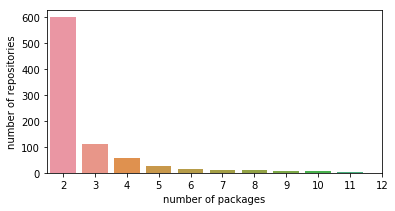

In [5]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='Package',
    data=(
        df_repo
        .groupby('Repository_URL')
        [['Package']]
        .count()
    ),
    ax=ax
)

ax.set(
    xlabel='number of packages',
    xlim=(None, 10),
    ylabel='number of repositories',
)

## Transform data

We define several criteria that will be used to identify main packages.
Let's first create two additionnal columns that compare the name of the package with the name of the repository.

In [6]:
def levenshtein(s1, s2):
    m=len(s1)+1
    n=len(s2)+1

    tbl = {}
    for i in range(m): tbl[i,0]=i
    for j in range(n): tbl[0,j]=j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            tbl[i,j] = min(tbl[i, j-1]+1, tbl[i-1, j]+1, tbl[i-1, j-1]+cost)

    return tbl[i,j]

In [7]:
from similarity.normalized_levenshtein import NormalizedLevenshtein
normalized_levenshtein = NormalizedLevenshtein()

In [8]:
for item in df_repo[lambda x: x['Repository'] == 'legacy'].Package:
    print(item + ' , \t legacy -> Levenshtein : ' + str(levenshtein(item,'legacy')) +  " \t Nlevenshtein : " + str(normalized_levenshtein.similarity(item,'legacy')))

serde07 , 	 legacy -> Levenshtein : 6 	 Nlevenshtein : 0.1428571428571429
serde06 , 	 legacy -> Levenshtein : 6 	 Nlevenshtein : 0.1428571428571429
serde08 , 	 legacy -> Levenshtein : 6 	 Nlevenshtein : 0.1428571428571429
serde1 , 	 legacy -> Levenshtein : 5 	 Nlevenshtein : 0.16666666666666663
serde09 , 	 legacy -> Levenshtein : 6 	 Nlevenshtein : 0.1428571428571429
legacy-serde , 	 legacy -> Levenshtein : 6 	 Nlevenshtein : 0.5


In [9]:
df_crit = (
    df_repo
    # Here we calculate levenshtein distance of package name and repository name
    .assign(name_match=lambda d: 
            (d.apply(lambda s: normalized_levenshtein.similarity(s['Package'].lower() , s['Repository'].lower()), axis=1))
    )
    # Compute age till 2019
    .assign(first_release_date=lambda d: 
            (d.apply(lambda s: pandas.Timedelta(pandas.to_datetime('2019-01-01 00:00:00') - s['first_release_date']).total_seconds()/86400 , axis=1))
    )
    # Compute day differece between this version and last version
    .groupby('Repository_URL', sort=False)
    .apply(lambda group:
        group.assign(
            first_release_date=lambda d: (d['first_release_date'].max()-d['first_release_date']),
        )
    )
    .reset_index(drop=True)
)

df_crit[lambda x:x['Repository_URL'] == 'https://github.com/serde-rs/legacy']

,Package,Repository_URL,Repository,versions,first_release_date,dependents,name_match
2647,serde07,https://github.com/serde-rs/legacy,legacy,1,0.000000,0,0.142857
2648,serde06,https://github.com/serde-rs/legacy,legacy,1,0.000000,0,0.142857
2649,serde08,https://github.com/serde-rs/legacy,legacy,1,0.000000,0,0.142857
2650,serde1,https://github.com/serde-rs/legacy,legacy,1,0.000694,0,0.166667
2651,serde09,https://github.com/serde-rs/legacy,legacy,1,0.000694,0,0.142857
2652,legacy-serde,https://github.com/serde-rs/legacy,legacy,4,0.001389,0,0.500000


We define several criteria, and we compute their value: a package that is "first" (even with draws) for a criterion will be selected as a "main package" according to that criterion.

In [10]:
criteria = ['closer_name', 'most_versions', 'first_released', 'most_dependents']

In [11]:
df_crit = (
    df_crit
    .groupby('Repository_URL', sort=False)
    .apply(lambda group:
        group.assign(
            
            most_versions=lambda d: (d['versions']/d['versions'].max()),
            # To handle cases which all packages have 0 distance from Last version in a repository (d['first_release_date'].max() == 0) I used np.where 
            first_released=lambda d: (1- np.where(d['first_release_date'].max() != 0, (d['first_release_date']/d['first_release_date'].max()),0)),
            # To handle cases which all packages have with 0 dependent package in a repository (d['dependents'].max() == 0) I used np.where
            most_dependents=lambda d: np.where(d['dependents'].max() != 0 , (d['dependents']/d['dependents'].max()),0),
            closer_name= lambda d: np.where( d['name_match'].max() != 0, (d['name_match']/d['name_match'].max()),0),
        )
    )
    .reset_index(drop=True)
    [['Package', 'Repository_URL'] + criteria]
)

We now rely on those criterion to identify main packages (they are not necessarily unique) for each repository.

In [12]:
df_crit = (
    df_crit
    .assign(criteria=lambda d: d[criteria].sum(axis=1))
    .groupby('Repository_URL', sort=False)
    .apply(lambda group: 
        group.assign(
            main=lambda d: (d['criteria'].rank(method='min', ascending=False) == 1),
        )
    )
    .reset_index(drop=True)
)

In [13]:
# This random_state incidentaly selects interesting examples
df_crit.sample(5, random_state=12345)

,Package,Repository_URL,closer_name,most_versions,first_released,most_dependents,criteria,main
469,cssparser-macros,https://github.com/servo/rust-cssparser,0.388889,0.058824,0.002741,0.142857,0.593310,False
2391,rocket,https://github.com/SergioBenitez/Rocket,1.000000,1.000000,1.000000,1.000000,4.000000,True
1523,tweetnacl-sys,https://github.com/jmesmon/sodalite,0.153846,0.266667,0.128098,1.000000,1.548611,False
2846,hyper-zipkin,https://github.com/palantir/rust-zipkin,1.000000,0.363636,0.999988,0.000000,2.363624,False
2669,enum-kinds-traits,https://bitbucket.org/Soft/enum-kinds,0.588235,0.750000,1.000000,0.000000,2.338235,False


## Main packages are not unique

Main packages are not unique. Because a package is tagged as "main" if it has the highest score, we could have draws. 
We look at how many repositories have more than one "main" package.

[Text(0, 0.5, 'number of repositories'),
 Text(0.5, 0, 'number of main packages')]

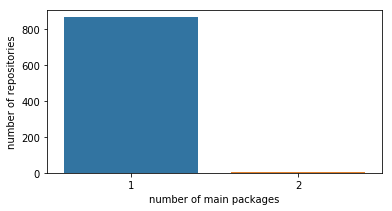

In [14]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='Package',
    data=(
        df_crit
        .query('main')
        .groupby('Repository_URL', sort=False)
        [['Package']]
        .count()
    ), 
    ax=ax,
)

ax.set(
    xlabel='number of main packages',
    ylabel='number of repositories',
    #yscale='log',
)

In [15]:
# To see repository with more than 1 main package
(
    df_crit
    .query('main')
    .groupby('Repository_URL', sort=False)
    .sum()
    [lambda d: d['main']>1]
)

,closer_name,most_versions,first_released,most_dependents,criteria,main
Repository_URL,,,,,,
https://github.com/ipgen/cli,1.000000,2.000000,1.0,0.0,4.000000,2.0
https://github.com/bluetech/pcsc-rust,1.666667,1.666667,1.0,1.0,5.333333,2.0
https://github.com/RustCrypto/asm-hashes,2.000000,2.000000,2.0,1.0,7.000000,2.0
https://github.com/Xudong-Huang/may,1.333333,1.666667,1.0,2.0,6.000000,2.0
https://github.com/sfackler/rstack,0.000000,2.000000,2.0,2.0,6.000000,2.0


One of the reason why repositories can have more than one package is because the "score" of these packages could be quite low, leading to more "draws". Let's check this hypothesis.

Let's now check what is the score in case of "draws". 

[Text(0, 0.5, 'number of repositories'),
 Text(0.5, 0, '"score" of of main packages')]

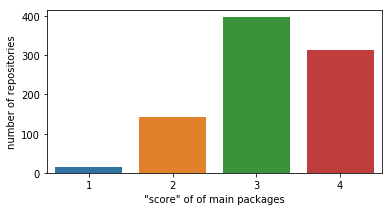

In [17]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.countplot(
    x='criteria',
    data=(
        df_crit
        .groupby('Repository_URL', sort=False)
        .apply(lambda group:
            group.assign(
                closer_name=lambda d: (d['closer_name'].rank(method='min', ascending=False) == 1),
                most_versions=lambda d: (d['most_versions'].rank(method='min', ascending=False) == 1),
                first_released=lambda d: (d['first_released'].rank(method='min', ascending=False) == 1),
                most_dependents=lambda d: (d['most_dependents'].rank(method='min', ascending=False) == 1),
            )
        )
        .reset_index(drop=True)
        .assign(criteria=lambda d: d[criteria].sum(axis=1))
        .query('main')
        .drop_duplicates(['Repository_URL', 'criteria'])
    ), 
    ax=ax,
)

ax.set(
    xlabel='"score" of of main packages',
    ylabel='number of repositories',
    #yscale='log',
)

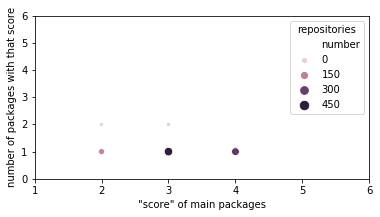

In [18]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.scatterplot(
    x='criteria',
    y='Package', 
    size='number',
    hue='number',
    data=(
        df_crit
        .groupby('Repository_URL', sort=False)
        .apply(lambda group:
            group.assign(
                closer_name=lambda d: (d['closer_name'].rank(method='min', ascending=False) == 1),
                most_versions=lambda d: (d['most_versions'].rank(method='min', ascending=False) == 1),
                first_released=lambda d: (d['first_released'].rank(method='min', ascending=False) == 1),
                most_dependents=lambda d: (d['most_dependents'].rank(method='min', ascending=False) == 1),
            )
        )
        .reset_index(drop=True)
        .assign(criteria=lambda d: d[criteria].sum(axis=1))
        .query('main')
        .groupby('Repository_URL', sort=False)
        .agg({'Package': 'count', 'criteria': 'max'})
        .assign(number=1)
        .groupby(['Package', 'criteria'], sort=False)
        .agg({'Package': 'first', 'criteria': 'first', 'number': 'count'})
        .reset_index(drop=True)
    ),
    ax=ax,
)

ax.set(
    xlabel='"score" of main packages',
    xlim=(1, 6),
    ylabel='number of packages with that score',
    ylim=(0, 6),
)

ax.legend(title='repositories')

This suggests that most "non-draws" have a score of 3 to 5, while most draws have a score of 2 or 3. 

## Criteria agreement

How many times each criterion leads to the same "answer" than "main"?

In [19]:
(
    df_crit
    .assign(**{
        # Use a double lambda to fix "c" in the closure of inner lambda
        c: (lambda c: (lambda d: d[c] == d['main']))(c) for c in criteria
    })
    [criteria]
    .pipe(lambda d: d.sum() / len(d))
)

closer_name        0.184416
most_versions      0.195671
first_released     0.447330
most_dependents    0.612698
dtype: float64

Obviously, not all cases are of interest. For instance, we would like to favour criteria that can be used to identify main packages, not criteria that can be used to identify non-main packages. We therefore compute the confusion matrix for each criterion.

In [20]:
# We do that in a loop because it's easier to write and we don't have that many data, so we can skip pandas' features this time ;-)
matrices = {
    c: dict(TP=0, FP=0, TN=0, FN=0)
    for c in criteria
}

for row in df_crit.itertuples():
    for criterion in criteria:
        if getattr(row, 'main'):
            if getattr(row, criterion):
                matrices[criterion]['TP'] += 1
            else:
                matrices[criterion]['FN'] += 1
        else:
            if getattr(row, criterion):
                matrices[criterion]['FP'] += 1
            else:
                matrices[criterion]['TN'] += 1

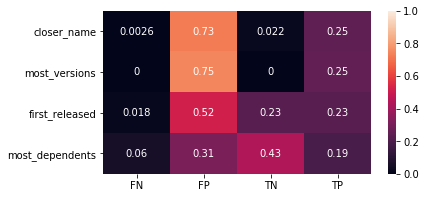

In [21]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=pandas.DataFrame(matrices).T / len(df_crit),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax
)


As this plot is not very useful, let's compute precision and recall for each criterion.
We also compute other metrics "just in case". 
Notice that "accuracy" is not very reliable here, because the classes are imbalanced.

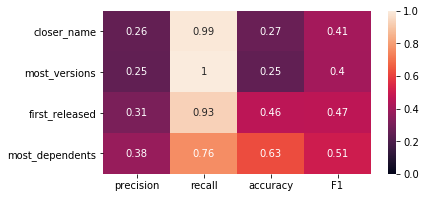

In [22]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        pandas.DataFrame(matrices)
        .T
        # Using eval to make it more readable and to we avoid the use of, e.g., d['TP'] + (d['TP'] + d['FP'])
        .eval('precision = TP / (TP + FP)')
        .eval('recall = TP / (TP + FN)')
        .eval('accuracy = (TP + TN) / (TP + TN + FP + FN)')
        .eval('F1 = 2 * TP / (2 * TP + FP + FN)')
        [['precision', 'recall', 'accuracy', 'F1']]
    ),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax
)

## Combinations of criteria

We look for combinations of criteria that could improve these scores. 

At first, we see pairwise correlations between them, to get a better idea of the possible redundancy.

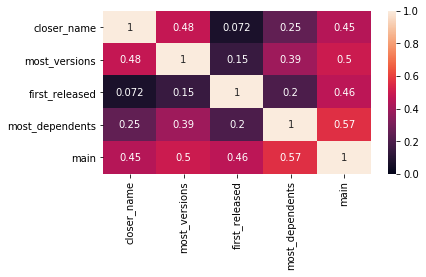

In [23]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        df_crit
        [criteria + ['main']]
        .corr()
    ),
    vmin=0, 
    vmax=1,
    annot=True,
    ax=ax,
)

Let's create some decision trees to see what could be the set of useful criteria. We should be careful because classes are imbalanced! 

In [24]:
df_crit['main'].value_counts()

False    2592
True      873
Name: main, dtype: int64

Let's balance classes:

In [25]:
from sklearn.utils import resample

df_balanced = pandas.concat([
    # First the "non-main packages" (majority)
    # Here query() is more readable than df_crit[~df_crit['main']]
    # or even than df_crit[lambda d: ~d['main']]
    df_crit.query('not main'),
    
    # Then we augment the minority class
    resample(
        df_crit.query('main'), 
        replace=True, 
        n_samples=len(df_crit.query('not main')),
        random_state=12345,
    )
])

df_balanced['main'].value_counts()

True     2592
False    2592
Name: main, dtype: int64

To avoid our models to overfit the data, we rely on a split validation. We avoid k-fold cross-validation at this point of the analysis because (1) it leads to k models, making the overall model more difficult to interpret and (2) it requires aggregating scores which could hide some interesting things at this point. The k-fold cross-validation will be performed later.

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df_balanced[criteria], 
    df_balanced['main'], 
    test_size=0.5, 
    random_state=12345  # For reproductibility purpose
)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

scores = {
    'recall': recall_score,
    'precision': precision_score,
    'accuracy': accuracy_score,
    'f1_score': f1_score,
}

We create a first tree based on all critera, just to have an idea on "how good" (or "how bad") it is.

In [28]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_pred = tree.predict(x_test)

for label, fun in scores.items():
    score = fun(y_test, y_pred)
    print(label, score)

recall 0.9734582357533177
precision 0.943267776096823
accuracy 0.9579475308641975
f1_score 0.9581252401075683


Let's have a look at the features:

In [29]:
pandas.DataFrame(index=criteria, data=tree.feature_importances_)

,0
closer_name,0.092411
most_versions,0.064410
first_released,0.698260
most_dependents,0.144919


It seems that not all features are equally important. We already spotted this from the correlation analysis we made earlier.

Let's try a naive approach in which we compute all possible combinations of features. 

In [30]:
# Recipe taken from https://docs.python.org/3/library/itertools.html
combinations = list(itertools.chain.from_iterable(itertools.combinations(criteria, r) for r in range(len(criteria)+1)))[1:]

In [31]:
results = pandas.DataFrame(index=combinations, columns=scores.keys())

for combination in combinations: 
    x_train, x_test, y_train, y_test = train_test_split(
        df_balanced[list(combination)], 
        df_balanced['main'], 
        test_size=0.5, 
        random_state=12345  # For reproductibility purpose
    )
    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    
    # Evaluate model
    y_pred = tree.predict(x_test)

    for label, fun in scores.items():
        score = fun(y_test, y_pred)
        results.at[combination, label] = score

In [32]:
# The following cell contains too many information, we will filter this later.
results

,recall,precision,accuracy,f1_score
"(closer_name,)",0.790008,0.766086,0.777006,0.777863
"(most_versions,)",0.874317,0.75067,0.794367,0.807789
"(first_released,)",0.910226,0.898305,0.904707,0.904226
"(most_dependents,)",0.728337,0.887726,0.820216,0.800172
"(closer_name, most_versions)",0.910226,0.796448,0.840664,0.849545
"(closer_name, first_released)",0.919594,0.902682,0.911265,0.91106
"(closer_name, most_dependents)",0.932084,0.825726,0.869213,0.875688
"(most_versions, first_released)",0.91491,0.909938,0.913194,0.912417
"(most_versions, most_dependents)",0.957845,0.787043,0.85108,0.864085
"(first_released, most_dependents)",0.986729,0.892025,0.934414,0.93699


In [33]:
# We compute ranks to ease identifying the "best" combinations
(
    results
    .assign(**{
        '{}_rank'.format(c): (lambda c: (lambda d: d[c].rank(method='min', ascending=False)))(c)
        for c in scores.keys()
    })
    .sort_values('f1_score_rank')
    .head(10)
)

,recall,precision,accuracy,f1_score,recall_rank,precision_rank,accuracy_rank,f1_score_rank
"(closer_name, most_versions, first_released, most_dependents)",0.974239,0.944739,0.959105,0.959262,2.0,1.0,1.0,1.0
"(most_versions, first_released, most_dependents)",0.967994,0.929535,0.947917,0.948375,4.0,2.0,2.0,2.0
"(closer_name, first_released, most_dependents)",0.968774,0.927504,0.947145,0.94769,3.0,3.0,3.0,3.0
"(first_released, most_dependents)",0.986729,0.892025,0.934414,0.93699,1.0,8.0,4.0,4.0
"(closer_name, most_versions, first_released)",0.923497,0.913514,0.918981,0.918478,8.0,4.0,5.0,5.0
"(most_versions, first_released)",0.91491,0.909938,0.913194,0.912417,10.0,5.0,6.0,6.0
"(closer_name, first_released)",0.919594,0.902682,0.911265,0.91106,9.0,6.0,7.0,7.0
"(first_released,)",0.910226,0.898305,0.904707,0.904226,11.0,7.0,8.0,8.0
"(closer_name, most_versions, most_dependents)",0.935207,0.861251,0.893519,0.896707,6.0,10.0,9.0,9.0
"(closer_name, most_dependents)",0.932084,0.825726,0.869213,0.875688,7.0,11.0,10.0,10.0


At this point, it looks like "most_versions" and "first_released" is the smallest subset of criteria that still provides very good results.

Because sklearn has a "feature ranking with recursive feature elimination" utility, we could achieve the same process using it. Also, I've just discovered this, so I want to play a little bit with it ;-)

In [34]:
from sklearn.feature_selection import RFE

results = pandas.DataFrame(index=range(1, len(criteria) + 1), columns=['features'] + list(scores.keys()))

x_train, x_test, y_train, y_test = train_test_split(
    df_balanced[criteria], 
    df_balanced['main'], 
    test_size=0.5, 
    random_state=12345  # For reproductibility purpose
)

for n_features in range(1, len(criteria) + 1):
    selector = RFE(DecisionTreeClassifier(), n_features)
    selector.fit(x_train, y_train)
    
    # Identify features
    results.at[n_features, 'features'] = pandas.np.extract(selector.support_, criteria)
    
    # Evaluate model
    y_pred = selector.predict(x_test)

    for label, fun in scores.items():
        score = fun(y_test, y_pred)
        results.at[n_features, label] = score

In [35]:
results

,features,recall,precision,accuracy,f1_score
1,[first_released],0.910226,0.898305,0.904707,0.904226
2,"[first_released, most_dependents]",0.986729,0.893286,0.935185,0.937685
3,"[closer_name, first_released, most_dependents]",0.968774,0.926811,0.946759,0.947328
4,"[closer_name, most_versions, first_released, m...",0.97502,0.944781,0.959491,0.959662
